# Model Deployment Class, replicating

In [76]:
from helper_functions import accuracy_fn, download_data, plot_decision_boundary, plot_loss_curves, plot_predictions, set_seeds
# from helper_functions import download_data, set_seeds, plot_loss_curves
from going_modular import engine, data_loaders
from going_modular import predictions
from going_modular.engine import train_step, test_step
from going_modular.utils import save_model
import mlxtend
from mlxtend.plotting import plot_confusion_matrix
import numpy as np
import os
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import random
import shutil
import requests
import sklearn
from sklearn.datasets import make_circles
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from torchinfo import summary
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from torchmetrics import Accuracy, ConfusionMatrix
import torchvision
from torchvision import datasets

from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import Tuple, Dict, List
writer = SummaryWriter()
import zipfile



In [77]:
# see torch and torch vision plus
print (torch.__version__)
print (torchvision.__version__)

2.3.0
0.18.0


In [78]:
# !nvcc --version

In [79]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def set_seeds (seed: int=42):
    """_summary_

    Args:
        seed (int, optional): _description_. Defaults to 42.
    """ 
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)   

In [80]:
import torch
torch.cuda.is_available()

True

In [81]:
# wet up data paths
# E:\Dropbox\GithubRepo\Udemy\pytorch-deep-learning-main\pytorch-deep-learning-main - Copy\data\pizza_steak_sushi_20_percent
data_20_percent_path = Path('../data/pizza_steak_sushi_20_percent')
train_dir = data_20_percent_path / 'train'
test_dir = data_20_percent_path / 'test'
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2_transforms = effnetb2_weights.transforms()
print (f'effnetb2 transforms: {effnetb2_transforms}')
# effnetb2 = torchvision.models.efficientnet_b2(weights="effnetb2_weights")
effnetb2 = torchvision.models.efficientnet_b2(weights="DEFAULT")

for param in effnetb2.parameters():
    param.requires_grad=False


effnetb2 transforms: ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


In [82]:
from torchinfo import summary
# effnetb2
summary(model=effnetb2,
        input_size= (1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   False
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16,

In [83]:
# get input size of last layer
effnetb2_lastlayer = list(effnetb2.children())[-1]
effnetb2_last_child_layer_inpu_count = list(effnetb2_lastlayer.children())[-1].in_features
effnetb2_last_child_layer_inpu_count

1408

In [84]:
set_seeds()
effnetb2.classifier=nn.Sequential(
    nn.Dropout(p = 0.3, inplace=True),
    nn.Linear(in_features=effnetb2_last_child_layer_inpu_count, out_features=3)

)

In [85]:
# function to create effnetb2
def create_effnetb2(output_feature_count:int, drop_out = 0.3, seed:int=42)-> nn.Module:
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms= weights.transforms()
    # model = torchvision.models.efficientnet_b2(weights="DEFAULT").to(device)
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    for param in model.features.parameters():
        param.requires_grad = False

    set_seeds()

    last_layer = list(model.children())[-1]
    last_child_layer = list(last_layer.children())[-1]
    last_input = last_child_layer.in_features

    model.classifier = nn.Sequential(
        nn.Dropout(p = drop_out, inplace=True),
        nn.Linear(in_features =last_input, 
                  out_features = output_feature_count).to(device))

    model.name = 'effnetb2'
    print (f'[INFO] created new {model.name} model')
    
    return model, transforms




In [86]:
effnetb2, effnetb2_transforms = create_effnetb2(output_feature_count=3)
effnetb2
print(summary(model=effnetb2,
        input_size= (1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names']))

effnetb2_transforms

[INFO] created new effnetb2 model
Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [87]:
# data loader
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_loaders.create_dataloaders(train_dir=train_dir, 
                                                                                          test_dir=test_dir, # use 10% data for testing
                                                                                          transform=effnetb2_transforms, 
                                                                                          batch_size=32)

In [88]:
len (train_dataloader_effnetb2), len (test_dataloader_effnetb2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [89]:
loss_fn = nn.CrossEntropyLoss()
effnetb2_optimizer = torch.optim.Adam(effnetb2.parameters(), lr=1e-3)

In [90]:
# general trainer

def train (model: torch.nn.Module,
           train_dataloader: torch.utils.data.DataLoader,
           test_dataloader: torch.utils.data.DataLoader,
           optimizer: torch.optim.Optimizer,
           loss_fn: torch.nn.Module,
           epochs: int,
           device: torch.device,
           writer: torch.utils.tensorboard.writer.SummaryWriter) -> Dict[str, List]:
    
    results = {'train_loss':[],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model = model,
                                           dataloader = train_dataloader,
                                           loss_fn = loss_fn,
                                           optimizer=optimizer,
                                           device = device)
        
        test_loss, test_acc = test_step(model = model,
                                        dataloader = test_dataloader,
                                        loss_fn = loss_fn,
                                        device=device)
        
        print (
            f'Epoch: {epoch + 1} |'
            f'train_loss: {train_loss:.4f} |'
            f'train_acc: {train_acc:.4f} |'
            f'test_loss {test_loss:.4f} |'
            f'test_acc:  {test_acc}:.4f'

        )

        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

    if writer:
        writer.add_scalars (main_tag = 'Accuracy',
                            tag_scalar_dict = {'train_acc': train_acc,
                                              'test_acc':test_acc},
                            global_step=epoch)
        writer.add_scalars (main_tag = 'Loss',
                           tag_scalar_dict = {'train_loss': train_loss,
                                              'test_loss' : test_loss},
                            global_step = epoch)
        
        writer.add_graph (model = model,
                          input_to_model = torch.randn(32, 3, 224, 224).to(device))# 3 or 1?
    
    writer.close()

    return results

In [91]:
# train effnetb2
set_seeds()

effnetb2_retults = train (model = effnetb2,
                          train_dataloader=train_dataloader_effnetb2,
                          test_dataloader=test_dataloader_effnetb2,
                          optimizer=effnetb2_optimizer,
                          loss_fn = loss_fn,
                          epochs = 10,
                          device=device,
                          writer=writer)

 10%|█         | 1/10 [00:05<00:46,  5.16s/it]

Epoch: 1 |train_loss: 0.9855 |train_acc: 0.5604 |test_loss 0.7407 |test_acc:  0.934659090909091:.4f


 20%|██        | 2/10 [00:10<00:42,  5.30s/it]

Epoch: 2 |train_loss: 0.7175 |train_acc: 0.8438 |test_loss 0.5869 |test_acc:  0.940909090909091:.4f


 30%|███       | 3/10 [00:15<00:36,  5.25s/it]

Epoch: 3 |train_loss: 0.5876 |train_acc: 0.8917 |test_loss 0.4909 |test_acc:  0.95:.4f


 40%|████      | 4/10 [00:20<00:31,  5.23s/it]

Epoch: 4 |train_loss: 0.4474 |train_acc: 0.9062 |test_loss 0.4355 |test_acc:  0.940909090909091:.4f


 50%|█████     | 5/10 [00:26<00:26,  5.22s/it]

Epoch: 5 |train_loss: 0.4290 |train_acc: 0.9104 |test_loss 0.3915 |test_acc:  0.9443181818181818:.4f


 60%|██████    | 6/10 [00:31<00:20,  5.21s/it]

Epoch: 6 |train_loss: 0.4380 |train_acc: 0.8896 |test_loss 0.3512 |test_acc:  0.96875:.4f


 70%|███████   | 7/10 [00:36<00:15,  5.17s/it]

Epoch: 7 |train_loss: 0.4245 |train_acc: 0.8771 |test_loss 0.3268 |test_acc:  0.95625:.4f


 80%|████████  | 8/10 [00:41<00:10,  5.27s/it]

Epoch: 8 |train_loss: 0.3897 |train_acc: 0.8958 |test_loss 0.3457 |test_acc:  0.9289772727272727:.4f


 90%|█████████ | 9/10 [00:47<00:05,  5.28s/it]

Epoch: 9 |train_loss: 0.3749 |train_acc: 0.8812 |test_loss 0.3129 |test_acc:  0.9130681818181818:.4f


100%|██████████| 10/10 [00:52<00:00,  5.26s/it]

Epoch: 10 |train_loss: 0.3757 |train_acc: 0.8604 |test_loss 0.2813 |test_acc:  0.96875:.4f


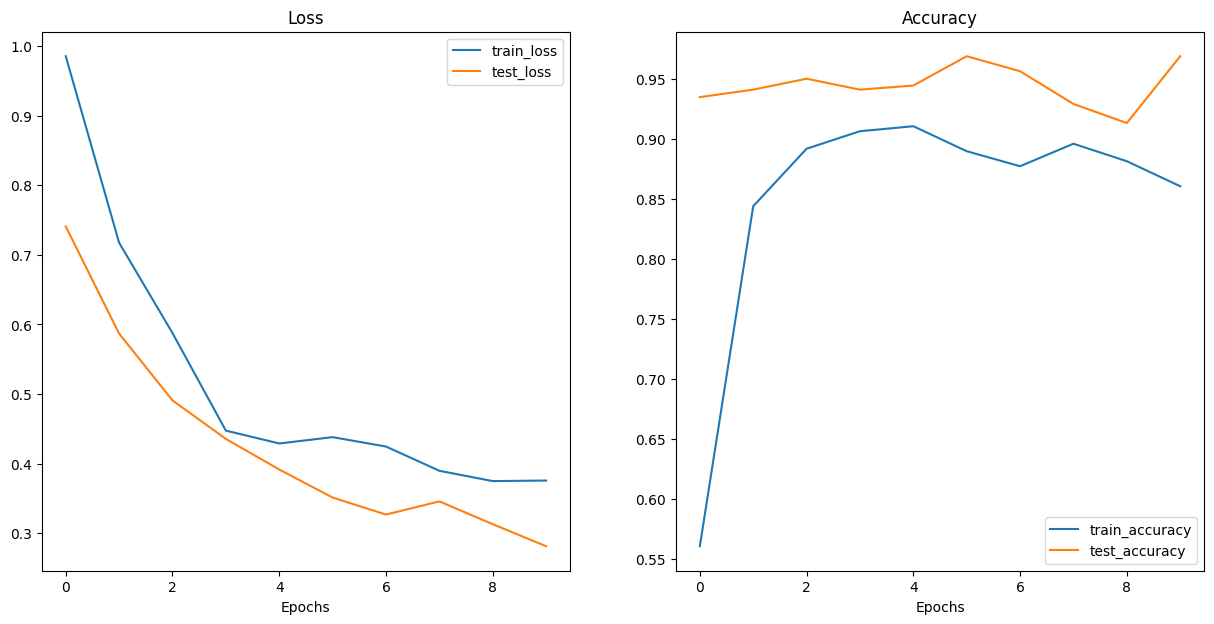

In [92]:
# !nvidia-smi
plot_loss_curves(effnetb2_retults)

### 3.5 Save the EffNetB2 feeature extractor

In [93]:
model_path = f"09_pre_trained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent_{10}_epochs.pth"
save_model (model = effnetb2,
            target_dir="models",
            model_name = model_path)

[INFO] Saving model to: models\09_pre_trained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent_10_epochs.pth


### 3.6 inspect size of EFFNetB2

In [94]:
pretrained_effnetb2_model_size = Path("models/", model_path).stat().st_size/(1024 * 1024)

### 3.7 Colling EffNetB2 feature extractor stats

In [95]:
# count number of paramters
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [96]:
effnetb2_stats = {'test_loss':effnetb2_retults['test_loss'][-1],
                  'test_acc':effnetb2_retults['test_acc'][-1],
                  'number_of_paramters': effnetb2_total_params,
                  'model_size (MB)': pretrained_effnetb2_model_size}

effnetb2_stats

{'test_loss': 0.2812606513500214,
 'test_acc': 0.96875,
 'number_of_paramters': 7705221,
 'model_size (MB)': 29.89214515686035}

## 4.0 ViT feature extractor

In [97]:
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [98]:
# list(list(vit.children())[-1])[-1].in_features

In [99]:
# create vit model
def create_vit_model(num_classes: int = 3, drop_out = 0.3, seed:int=42)-> nn.Module:
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    model= torchvision.models.vit_b_16(weights=weights).to(device)
    transforms=weights.transforms()

    for param in model.parameters():
        param.requires_grad = False

    set_seeds(seed=seed)

    last_layer = list (model.children())[-1]
    last_child_layer = list (last_layer.children())[-1]
    last_input = last_child_layer.in_features

    model.heads = nn.Sequential(
        nn.Dropout(p = drop_out, inplace=True),
        nn.Linear(in_features=last_input,
                  out_features=num_classes).to(device))
    
    model.name = 'ViT_B_16'
    print (f'[INFO] created new {model.name} model')

    return model, transforms

In [100]:
vit, vit_transforms = create_vit_model(num_classes=3)

print(summary(model=vit,
        input_size= (1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names']))

vit_transforms

[INFO] created new ViT_B_16 model
Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)           

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [101]:
effnetb2, effnetb2_transforms = create_effnetb2(output_feature_count=3)
effnetb2
print(summary(model=effnetb2,
        input_size= (1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names']))

effnetb2_transforms

[INFO] created new effnetb2 model
Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

### 4.1 ViT Dataloader

In [102]:
# data loader
train_dataloader_vit, test_dataloader_vit, class_names = data_loaders.create_dataloaders(train_dir=train_dir, 
                                                                                          test_dir=test_dir, # use 10% data for testing
                                                                                          transform=vit_transforms, 
                                                                                          batch_size=32)

### 4.2 Vit training

In [103]:
loss_fn = nn.CrossEntropyLoss()
vit_optimizer = torch.optim.Adam(vit.parameters(), lr=1e-3)

In [104]:
# train vit
set_seeds()

vit_retults = train (model = vit,
                          train_dataloader=train_dataloader_vit,
                          test_dataloader=test_dataloader_vit,
                          optimizer=vit_optimizer,
                          loss_fn = loss_fn,
                          epochs = 10,
                          device=device,
                          writer=writer)

 10%|█         | 1/10 [00:05<00:53,  5.92s/it]

Epoch: 1 |train_loss: 0.7245 |train_acc: 0.7250 |test_loss 0.2896 |test_acc:  0.9289772727272727:.4f


 20%|██        | 2/10 [00:11<00:45,  5.75s/it]

Epoch: 2 |train_loss: 0.2648 |train_acc: 0.9083 |test_loss 0.1720 |test_acc:  0.9602272727272727:.4f


 30%|███       | 3/10 [00:17<00:39,  5.68s/it]

Epoch: 3 |train_loss: 0.1975 |train_acc: 0.9479 |test_loss 0.1281 |test_acc:  0.9693181818181819:.4f


 40%|████      | 4/10 [00:22<00:34,  5.67s/it]

Epoch: 4 |train_loss: 0.1410 |train_acc: 0.9604 |test_loss 0.1085 |test_acc:  0.972159090909091:.4f


 50%|█████     | 5/10 [00:28<00:27,  5.60s/it]

Epoch: 5 |train_loss: 0.1234 |train_acc: 0.9646 |test_loss 0.0965 |test_acc:  0.978409090909091:.4f


 60%|██████    | 6/10 [00:33<00:22,  5.63s/it]

Epoch: 6 |train_loss: 0.1387 |train_acc: 0.9354 |test_loss 0.0846 |test_acc:  0.972159090909091:.4f


 70%|███████   | 7/10 [00:39<00:16,  5.57s/it]

Epoch: 7 |train_loss: 0.1079 |train_acc: 0.9625 |test_loss 0.0831 |test_acc:  0.9875:.4f


 80%|████████  | 8/10 [00:45<00:11,  5.58s/it]

Epoch: 8 |train_loss: 0.1237 |train_acc: 0.9437 |test_loss 0.0761 |test_acc:  0.978409090909091:.4f


 90%|█████████ | 9/10 [00:50<00:05,  5.48s/it]

Epoch: 9 |train_loss: 0.1052 |train_acc: 0.9771 |test_loss 0.0750 |test_acc:  0.978409090909091:.4f


100%|██████████| 10/10 [00:55<00:00,  5.56s/it]

Epoch: 10 |train_loss: 0.0786 |train_acc: 0.9854 |test_loss 0.0640 |test_acc:  1.0:.4f



c:\Users\Tiger\anaconda3\envs\Py311UdemyWCUDA1\Lib\site-packages\torch\__init__.py:1559: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert condition, message


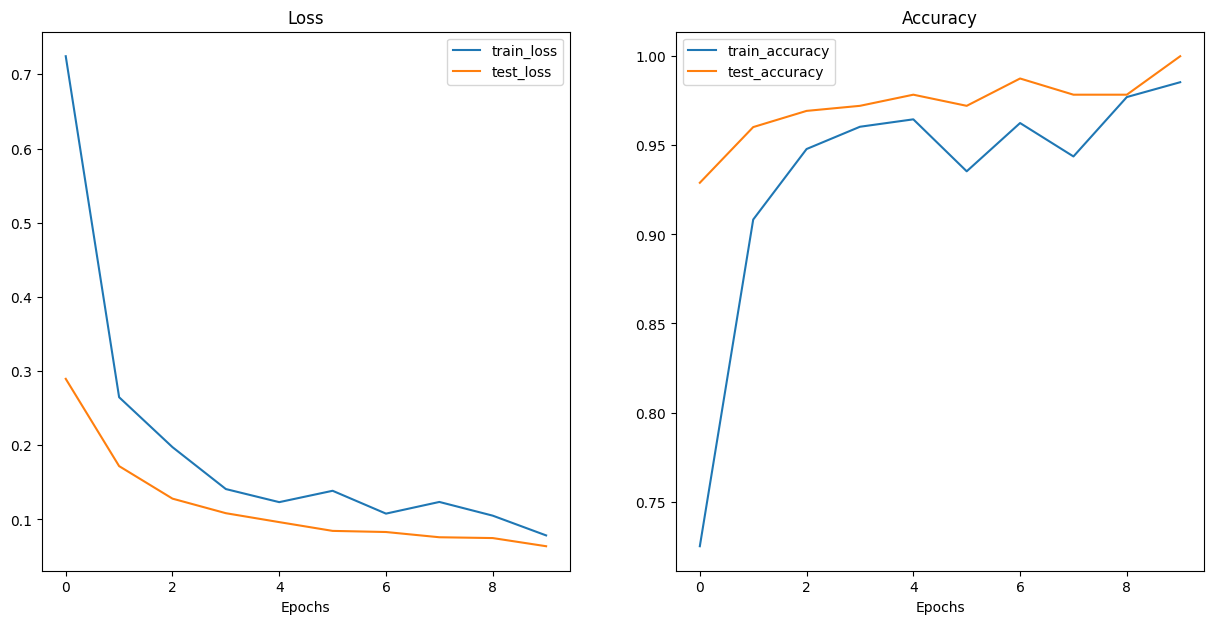

In [105]:
# train effnetb2
plot_loss_curves(vit_retults)

### 4.3 Save the fit feeature extractor

In [106]:
vit_model_path = f"09_pre_trained_vit_feature_extractor_pizza_steak_sushi_20_percent_{10}_epochs.pth"
save_model (model = vit,
            target_dir="models",
            model_name = vit_model_path)

[INFO] Saving model to: models\09_pre_trained_vit_feature_extractor_pizza_steak_sushi_20_percent_10_epochs.pth


### 4.4 inspect size of vit

In [107]:
pretrained_vit_model_size = Path("models/", vit_model_path).stat().st_size/(1024 * 1024)
pretrained_vit_model_size

327.38194465637207

### 4.6 Collecting vit feature extractor stats

In [108]:
# count number of paramters
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [109]:
vit_stats = {'test_loss':vit_retults['test_loss'][-1],
                  'test_acc':vit_retults['test_acc'][-1],
                  'number_of_paramters': vit_total_params,
                  'model_size (MB)': pretrained_vit_model_size}

vit_stats

{'test_loss': 0.06396642997860909,
 'test_acc': 1.0,
 'number_of_paramters': 85800963,
 'model_size (MB)': 327.38194465637207}

## 5. Making Prediction swith our trained data models


In [110]:
# Get all test data paths
# from tqdm import tqdm
# from pathlib import Path
# test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
# test_labels = [path.parent.stem for path in test_data_paths]
# Create a function to return a list of dictionaries with sample, label, prediction, pred prob
def pred_and_store(test_paths, model, transform, class_names, device):
  test_pred_list = []
  for path in tqdm(test_paths):
    # Create empty dict to store info for each sample
    pred_dict = {}

    # Get sample path
    pred_dict["image_path"] = path

    # Get class name
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    #520cc050-f648-4d4d-b7ae-16850d1a8fbd Get prediction and prediction probability
    from PIL import Image
    
    # 6. timer
    start_time = timer()

    img = Image.open(path) # open image
    transformed_image = transform(img).unsqueeze(0) # transform image and add batch dimension
    model.eval()
    with torch.inference_mode():
      pred_logit = model(transformed_image.to(device))
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      # pred_class = class_names[pred_label.cpu()]
      pred_class = class_names[pred_label.cpu()]

      # Make sure things in the dictionary are back on the CPU 
      pred_dict["pred_prob"] = pred_prob.unsqueeze(0).max().cpu().item()
      pred_dict["pred_class"] = pred_class

      # 12. End timerer
      end_time = timer()
      pred_dict["time_for_pred"] = round (end_time - start_time, 4)
  
    # Does the pred match the true label?
    pred_dict["correct"] = class_name == pred_class

    # print(pred_dict)
    # Add the dictionary to the list of preds
    test_pred_list.append(pred_dict)

  return test_pred_list

# test_pred_dicts = pred_and_store(test_paths=test_data_paths,
#                                  model=pretrained_vit_swag,
#                                  transform=vit_transforms_swag,
#                                  class_names=class_names,
#                                  device=device)

# test_pred_dicts[:5]

In [111]:
# test on vit
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_labels = [path.parent.stem for path in test_data_paths]
test_pred_dicts_vit = pred_and_store(test_paths=test_data_paths,
                                 model=vit,
                                 transform=vit_transforms,
                                 class_names=class_names,
                                 device=device)

test_pred_dicts_vit[:5]

100%|██████████| 150/150 [00:02<00:00, 61.76it/s]


[{'image_path': WindowsPath('../data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9985803365707397,
  'pred_class': 'pizza',
  'time_for_pred': 0.0162,
  'correct': True},
 {'image_path': WindowsPath('../data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9952054023742676,
  'pred_class': 'pizza',
  'time_for_pred': 0.0185,
  'correct': True},
 {'image_path': WindowsPath('../data/pizza_steak_sushi_20_percent/test/pizza/1067986.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9984466433525085,
  'pred_class': 'pizza',
  'time_for_pred': 0.017,
  'correct': True},
 {'image_path': WindowsPath('../data/pizza_steak_sushi_20_percent/test/pizza/129666.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9858282804489136,
  'pred_class': 'pizza',
  'time_for_pred': 0.0171,
  'correct': True},
 {'image_path': WindowsPath('../data/pizza_steak_sushi_20_percent/test/pizza/1315645.jpg'),
  'class_name'

In [112]:
# 
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_labels = [path.parent.stem for path in test_data_paths]
test_pred_dicts_effnetb2 = pred_and_store(test_paths=test_data_paths,
                                 model=effnetb2,
                                 transform=effnetb2_transforms,
                                 class_names=class_names,
                                 device=device)

test_pred_dicts_effnetb2[:5]

100%|██████████| 150/150 [00:04<00:00, 34.51it/s]


[{'image_path': WindowsPath('../data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.40349331498146057,
  'pred_class': 'sushi',
  'time_for_pred': 0.0287,
  'correct': False},
 {'image_path': WindowsPath('../data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.3899497091770172,
  'pred_class': 'sushi',
  'time_for_pred': 0.0276,
  'correct': False},
 {'image_path': WindowsPath('../data/pizza_steak_sushi_20_percent/test/pizza/1067986.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.36351701617240906,
  'pred_class': 'sushi',
  'time_for_pred': 0.0281,
  'correct': False},
 {'image_path': WindowsPath('../data/pizza_steak_sushi_20_percent/test/pizza/129666.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.36818185448646545,
  'pred_class': 'sushi',
  'time_for_pred': 0.0301,
  'correct': False},
 {'image_path': WindowsPath('../data/pizza_steak_sushi_20_percent/test/pizza/1315645.jpg'),
  'cla

In [113]:
effnet2b_test_pred_df = pd. DataFrame(test_pred_dicts_effnetb2)
effnet2b_test_pred_df.head(2)

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,..\data\pizza_steak_sushi_20_percent\test\pizz...,pizza,0.403493,sushi,0.0287,False
1,..\data\pizza_steak_sushi_20_percent\test\pizz...,pizza,0.389950,sushi,0.0276,False


In [114]:
# check number of correct predictions
effnet2b_test_pred_df.correct.value_counts()

correct
False    117
True      33
Name: count, dtype: int64

In [115]:
# Find the average time per prediction
effnetb2_average_time_per_pred = round(effnet2b_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred} seconds")

EffNetB2 average time per prediction: 0.0287 seconds


In [116]:
effnetb2_stats['time_per_pred_cpu'] =effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.2812606513500214,
 'test_acc': 0.96875,
 'number_of_paramters': 7705221,
 'model_size (MB)': 29.89214515686035,
 'time_per_pred_cpu': 0.0287}

###  5.3 get statsfor stats VIT

In [117]:
# create DF
vit_test_pred_df = pd.DataFrame(test_pred_dicts_vit)
vit_test_pred_df.head(2)

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,..\data\pizza_steak_sushi_20_percent\test\pizz...,pizza,0.998580,pizza,0.0162,True
1,..\data\pizza_steak_sushi_20_percent\test\pizz...,pizza,0.995205,pizza,0.0185,True


In [118]:
# Count the number of correct predictions
vit_test_pred_df.correct.value_counts()

correct
True    150
Name: count, dtype: int64

In [119]:
# get average
vit_average_time_per_pred = round (vit_test_pred_df.time_for_pred.mean(), 4)
vit_average_time_per_pred

0.016

In [120]:
vit_stats['time_per_pred_cpu'] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.06396642997860909,
 'test_acc': 1.0,
 'number_of_paramters': 85800963,
 'model_size (MB)': 327.38194465637207,
 'time_per_pred_cpu': 0.016}

## 6. Comparing models 

In [121]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])
df['model'] = ["EffNetB2", "ViT"]
df['test_acc'] = round (df['test_acc'] * 100, 2)
df

,test_loss,test_acc,number_of_paramters,model_size (MB),time_per_pred_cpu,model
0,0.281261,96.88,7705221,29.892145,0.0287,EffNetB2
1,0.063966,100.00,85800963,327.381945,0.0160,ViT


In [122]:
# compare Vit to EffNetB2
pd.DataFrame(data= (df.set_index('model').loc['ViT']/df.set_index('model').loc['EffNetB2']),
                        columns = ['Fit to EffNetB2 ratios']).T

,test_loss,test_acc,number_of_paramters,model_size (MB),time_per_pred_cpu
Fit to EffNetB2 ratios,0.227428,1.032205,11.135432,10.952106,0.557491


### 6.1 Visulaizeing speed vs performance

<function matplotlib.pyplot.show(close=None, block=None)>

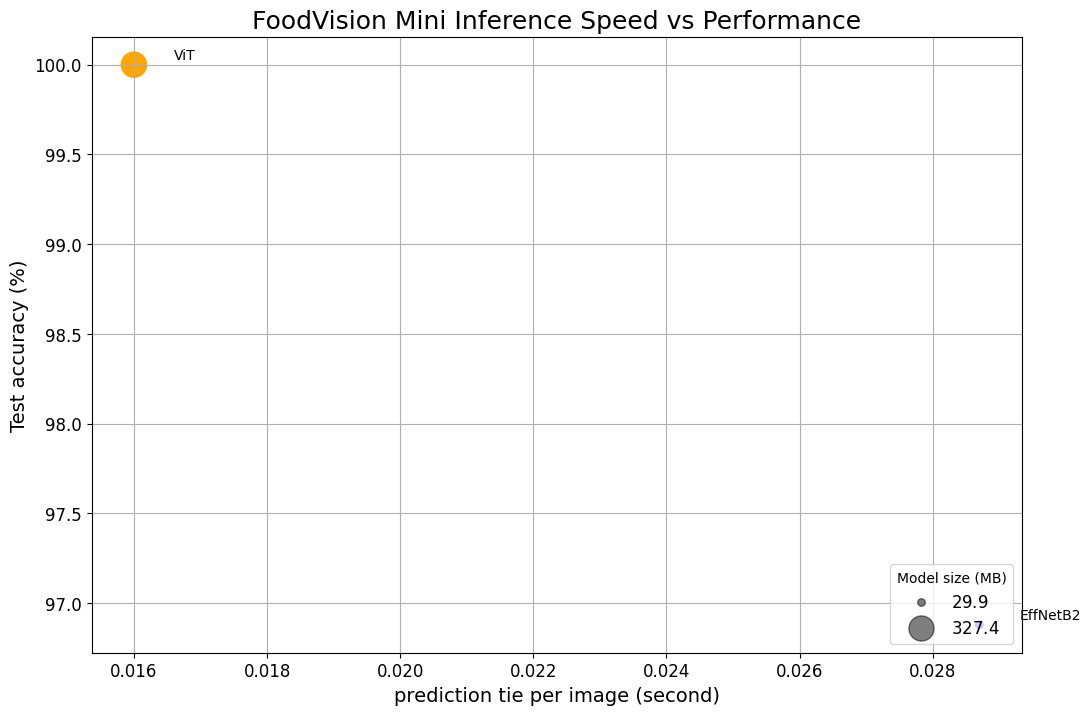

In [123]:
fig, ax = plt.subplots(figsize= (12, 8))
scatter = ax.scatter(data= df,
                     x = 'time_per_pred_cpu',
                     y = 'test_acc',
                     c = ['blue', 'orange'],
                     s = 'model_size (MB)')
ax.set_title ("FoodVision Mini Inference Speed vs Performance", fontsize = 18)
ax.set_xlabel("prediction tie per image (second)", fontsize = 14)
ax.set_ylabel("Test accuracy (%)", fontsize = 14)
ax.tick_params (axis = 'both', labelsize = 12)

ax.grid (True)

# 3. annotate
for index, row in df.iterrows():
    ax.annotate(text = row['model'],
                xy = (row['time_per_pred_cpu']+0.0006, row ['test_acc']+0.03))
    
#  4. Create legedn
handles, labels = scatter.legend_elements (prop='sizes', alpha = 0.5)
models_size_legend = ax.legend(handles,
                               labels,
                               loc = 'lower right',
                               title = "Model size (MB)",
                               fontsize = 12)

plt.show

## 7. Food Vision minto on Gradio

In [124]:
# 

In [125]:
# import/install gradio
try: 
    import gradio as gr  
except:
    !pip -q install gradio
    import gradio as gr

print (f'Gradio version {gr.__version__}')

Gradio version 5.9.1


In [126]:
# put model to cput
effnetb2.to('cpu')
next(iter(effnetb2.parameters())).device

device(type='cpu')

In [127]:
# recreate workflow
def predict(img) ->Tuple [Dict, float]:

    start_time = timer()

    img = effnetb2_transforms(img).unsqueeze(0)

    effnetb2.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(effnetb2(img), dim = 1)

    pred_labels_probs = {class_names[i]:float (pred_probs[0][i]) for i in range (len(class_names))}

    pred_time = round (timer() - start_time , 5)

    return pred_labels_probs, pred_time


In [128]:
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

random_image_path = random.sample (test_data_paths, k = 1)[0]

image = Image.open(random_image_path)

print (f'[INFO] Prediction on image at path: {random_image_path}\n')
pred_dict, pred_time = predict (img = image)
print (f'label and prbob:\n{pred_dict}')
print (f'Prediction Time : {pred_time} seconds')

[INFO] Prediction on image at path: ..\data\pizza_steak_sushi_20_percent\test\sushi\1063878.jpg

label and prbob:
{'pizza': 0.3609239459037781, 'steak': 0.2757018506526947, 'sushi': 0.363374263048172}
Prediction Time : 0.10973 seconds


### 7.3 Creating example list

In [129]:
example_list = [[str(filepath)] for filepath in random.sample (test_data_paths, k = 3)]
example_list

[['..\\data\\pizza_steak_sushi_20_percent\\test\\sushi\\1245545.jpg'],
 ['..\\data\\pizza_steak_sushi_20_percent\\test\\sushi\\46797.jpg'],
 ['..\\data\\pizza_steak_sushi_20_percent\\test\\steak\\1882831.jpg']]

### 7.4 Build a Gradiao interface

In [130]:
title = "Food vision Mini 🍕🥩🍣"
description = "an EfficentNetB2 feature extract"
article = "Created at Hassan 09"

demo = gr.Interface(fn=predict,
                    inputs = gr.Image(type='pil'),
                    outputs = [gr.Label(num_top_classes = 3, label = "Prdictions"),
                                gr.Number(label = "prediction time")],
                    examples = example_list,
                    title = title,
                    description=description,
                    article=article)

# demo.launch(debug=False,
#            share=True)

## 8. Put FoodVision Mini on Gradio into a deployable app

### Creating a demo folder 

In [131]:
# creae good vision demo path
food_mini_demo_path = Path('demos/foodvision_mini/')

if food_mini_demo_path.exists():
    # shutil.rmtree(food_mini_demo_path)
    # food_mini_demo_path.mkdir(parents=True,
    #                           exist_ok=True)
    pass
    
else:
        food_mini_demo_path.mkdir(parents=True,
                                  exist_ok=True)
        
!ls demo/foodvision_min/
# print(os.listdir(food_mini_demo_path))

'ls' is not recognized as an internal or external command,
operable program or batch file.


### 8.4 Creating voder for exampels


In [132]:
foodvision_mini_examples_path =food_mini_demo_path / 'examples'

foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# E:\Dropbox\GithubRepo\Udemy\pytorch-deep-learning-main\pytorch-deep-learning-main - Copy\data\pizza_steak_sushi_20_percent\test
# 
# file_list =  '/pizza/' + '2582289.jpg', '/steak/' + '3622237.jpg', '/steak/' + '2582289.jpg')
# foodvision_mini_examples_path = ;.join ()
foodvision_mini_examples = [Path(test_dir / 'pizza' / '44810.jpg' ),
                                 Path(test_dir / 'sushi' / '46797.jpg'),
                                 Path(test_dir / 'steak' / '39461.jpg')]

# pizza_example = test_dir /'pizza/' + '2582289.jpg')
# steak_example = file('steak/' + '3622237.jpg')
# sushi_exampel = file('sushi' + '592799.jpg')


# foodvision_mini_examples_path = [test_dir / file('pizza/2582289.jpg') ,
#                                  test_dir / file('steak/3622237.jpg'),
#                                  test_dir / file('sushi/592799.jpg')]
for example in foodvision_mini_examples:
        destination = foodvision_mini_examples_path / example.name
        print (f'[INFO] Copying {example} to {destination}')
        shutil.copy2(src=example, dst=destination)



[INFO] Copying ..\data\pizza_steak_sushi_20_percent\test\pizza\44810.jpg to demos\foodvision_mini\examples\44810.jpg
[INFO] Copying ..\data\pizza_steak_sushi_20_percent\test\sushi\46797.jpg to demos\foodvision_mini\examples\46797.jpg
[INFO] Copying ..\data\pizza_steak_sushi_20_percent\test\steak\39461.jpg to demos\foodvision_mini\examples\39461.jpg


### 8.5 moving EffnetB2 to FoodVision Mini demo

In [133]:
# soure path
effnetb2_foodvision_mini_model_path_new = f"models/09_pre_trained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent_{10}_epochs.pth"

effnetb2_foodvision_mini_model_destination = food_mini_demo_path / effnetb2_foodvision_mini_model_path_new.split("/")[1]

try:
    print (f'[INFO] attempting to move {effnetb2_foodvision_mini_model_path} to  {effnetb2_foodvision_mini_model_destination}') 

    # move model
    shutil.move(src= effnetb2_foodvision_mini_model_path_new, dst = effnetb2_foodvision_mini_model_destination)

    print (f'[INfO] model move complete')

except:
        print (f'[INFO] move failed')


[INFO] move failed


### 8.6 Turn EffnetB2 model a python script

In [134]:
%%writefile demos/foodvision_mini/model.py
# function to create effnetb2
import torch
import torchvision

from torch import nn

def create_effnetb2_model (output_feature_count:int=3, drop_out = 0.3, seed:int=42)-> nn.Module:
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms= weights.transforms()
    # model = torchvision.models.efficientnet_b2(weights="DEFAULT").to(device)
    # model = torchvision.models.efficientnet_b2(weights=weights).to(device)
    model = torchvision.models.efficientnet_b2(weights=weights)


    # for param in model.features.parameters():
    for param in model.parameters():
                param.requires_grad = False

    # set_seeds()
    torch.manual_seed(seed)

    last_layer = list(model.children())[-1]
    last_child_layer = list(last_layer.children())[-1]
    last_input = last_child_layer.in_features

    model.classifier = nn.Sequential(
        nn.Dropout(p = drop_out, inplace=True),
        nn.Linear(in_features =last_input, 
                #   out_features = output_feature_count).to(device))
                  out_features = output_feature_count))                 

    # model.name = 'effnetb2'
    # print (f'[INFO] created new {model.name} model')
    
    return model, transforms

Overwriting demos/foodvision_mini/model.py


### 8.7 Turning our FoodVision Mini Gradio app into a Python script (`app.py`)

In [135]:
%%writefile demos/foodvision_mini/app.py
# 1. import and setup
import gradio as gr
import os
import torch

from model import create_effnetb2_model # put back in
from timeit import default_repeat as timer  
from typing import Tuple, Dict

class_names = ['pizza', 'steak', 'sushi']


# 2. Models and Transforms
effnetb2, effnetb2_transforms = create_effnetb2_model(output_feature_count=3)

effnetb2.load_state_dict(
    torch.load(
        # f=f"models/09_pre_trained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent_{10}_epochs.pth",
        f=f"09_pre_trained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent_{10}_epochs.pth",        
        map_location=torch.device('cpu'),
        weights_only = True
    )
)

# 3. Predict Funciton
# def predict(img) -> Tuple[Dict, float]
# recreate workflow
def predict(img) ->Tuple [Dict, float]:
    from timeit import default_timer as timer
    start_time = timer()

    img = effnetb2_transforms(img).unsqueeze(0)

    effnetb2.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(effnetb2(img), dim = 1)

    pred_labels_probs = {class_names[i]:float (pred_probs[0][i]) for i in range (len(class_names))}

    pred_time = round (timer() - start_time , 5)

    return pred_labels_probs, pred_time

#  Gradio Ap
title = "Food vision Mini 🍕🥩🍣"
description = "an EfficentNetB2 feature extract"
article = "Created at Hassan 09"

# these will likely cause problems in relative paths. Need to fix. 
# example_list = [[str(filepath)] for filepath in random.sample (test_data_paths, k = 3)]
example_list = [['examples/' + example] for example in os.listdir('examples')]

demo = gr.Interface(fn=predict,
                    inputs = gr.Image(type='pil'),
                    outputs = [gr.Label(num_top_classes = 3, label = "Predictions"),
                                gr.Number(label = "prediction time")],
                    examples = example_list,
                    title = title,
                    description=description,
                    article=article)

demo.launch(debug=False,
           share=True)

Overwriting demos/foodvision_mini/app.py


In [136]:
# %pwd
# demo.launch(debug=False,
#            share=True)

### 8.8 make requirments text

In [137]:
%%writefile demos/foodvision_mini/requirements.txt
torch
torchvision
gradio

Overwriting demos/foodvision_mini/requirements.txt


## 9. Deploying FoodVisoin Minto to huggingface spaces


In [138]:
# !dir demos\foodvision_mini

In [139]:
import os
import zipfile

# Define source and destination
source_dir = 'demos/foodvision_mini'
zip_path = 'demos/foodvision_mini.zip'

# Create a ZIP file excluding unwanted patterns
def zip_excluding(source_dir, zip_path, exclude_patterns):
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(source_dir):
            # Exclude patterns for directories
            dirs[:] = [d for d in dirs if not any(ex in os.path.join(root, d) for ex in exclude_patterns)]
            # Exclude patterns for files
            for file in files:
                if not any(ex in os.path.join(root, file) for ex in exclude_patterns):
                    zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), source_dir))

exclude = ['.pyc', '.ipynb', '__pycache__', 'ipynb_checkpoints']
zip_excluding(source_dir, zip_path, exclude)

print(f"Zipped to {zip_path}")


Zipped to demos/foodvision_mini.zip


## 10. Creating FoodVision Big

We've spent the past few sections and chapters working on bringing FoodVision Mini to life.

And now we've seen it working in a live demo, how about we step things up a notch?

How?

FoodVision Big!

Since FoodVision Mini is trained on pizza, steak and sushi images from the [Food101 dataset](https://pytorch.org/vision/main/generated/torchvision.datasets.Food101.html) (101 classes of food x 1000 images each), how about we make FoodVision Big by training a model on all 101 classes!

We'll go from three classes to 101!

From pizza, steak, sushi to pizza, steak, sushi, hot dog, apple pie, carrot cake, chocolate cake, french fires, garlic bread, ramen, nachos, tacos and more!

How?

Well, we've got all the steps in place, all we have to do is alter our EffNetB2 model slightly as well as prepare a different dataset.

To finish Milestone Project 3, let's recreate a Gradio demo similar to FoodVision Mini (three classes) but for FoodVision Big (101 classes).

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/09-model-deployment-foodvision-mini-to-foodvision-big.png" alt="foodvision mini model on three classes: pizza, steak, sushi and foodvision big on all of the 101 classes in the food101 dataset" width=900/>

*FoodVision Mini works with three food classes: pizza, steak and sushi. And FoodVision Big steps it up a notch to work across 101 food classes: all of the [classes in the Food101 dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/food101_class_names.txt).*

### 10.1 Creating a model and transforms for FoodVision Big

When creating FoodVision Mini we saw that the EffNetB2 model was a good tradeoff between speed and performance (it performed well with a fast speed).

So we'll continue using the same model for FoodVision Big.

We can create an EffNetB2 feature extractor for Food101 by using our `create_effnetb2_model()` function we created above, in [section 3.1](https://www.learnpytorch.io/09_pytorch_model_deployment/#31-creating-a-function-to-make-an-effnetb2-feature-extractor), and passing it the parameter `num_classes=101` (since Food101 has 101 classes).

In [141]:
#  create effnetb2 model capable of fitting to 101 classes for Food101
# effnetb2_food101, effnetb2_transforms = create_effnetb2_model(output_feature_count = 101)
effnetb2_food101, effnetb2_transforms = create_effnetb2(output_feature_count = 101)

[INFO] created new effnetb2 model


In [142]:
#  get summary
summary (effnetb2_food101,
         input_size=(1, 3, 224, 224),
         col_names = ["input_size", "output_size", "num_params", "trainable"],
         col_width = 20,
         row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/09-effnetb2-feature-extractor-101-classes.png" width=900 alt="effnetb2 feature extractor with 100 output classes model summary"/>
                                                                                                                                                      
Nice!

See how just like our EffNetB2 model for FoodVision Mini the base layers are frozen (these are pretrained on ImageNet) and the outer layers (the `classifier` layers) are trainble with an ouput shape of `[batch_size, 101]` (`101` for 101 classes in Food101). 

Now since we're going to be dealing with a fair bit more data than usual, how about we add a little data augmentation to our transforms (`effnetb2_transforms`) to augment the training data.

> **Note:** Data augmentation is a technique used to alter the appearance of an input training sample (e.g. rotating an image or slightly skewing it) to artificially increase the diversity of a training dataset to hopefully prevent overfitting. You can see more on data augmentation in [04. PyTorch Custom Datasets section 6](https://www.learnpytorch.io/04_pytorch_custom_datasets/#6-other-forms-of-transforms-data-augmentation).

Let's compose a `torchvision.transforms` pipeline to use [`torchvision.transforms.TrivialAugmentWide()`](https://pytorch.org/vision/main/generated/torchvision.transforms.TrivialAugmentWide.html) (the same data augmentation used by the PyTorch team in their [computer vision recipes](https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/#break-down-of-key-accuracy-improvements)) as well as the `effnetb2_transforms` to transform our training images.

In [143]:
# create Foo101 training data
food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms,
])

In [144]:
print(f'Traning transforms:\n{food101_train_transforms}\n')
print(f'Testing transforms:\n{effnetb2_transforms} ')

Traning transforms:
Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

Testing transforms:
ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
) 


In [145]:
# set up data path
data_dir = Path('../data/food-101') # idfferent from 
# data_dir = '../data/food-101'
# use local for training
train_data = datasets.Food101 (root= data_dir,
                               split = 'train',
                               transform=food101_train_transforms,
                               download = False)

test_data = datasets.Food101(root=data_dir,
                            split= 'test',
                            transform=effnetb2_transforms,
                            download = False)



In [ ]:
# import tarfile

# file_path = "../data/food-101.tar.gz"
# extract_path = "../data/food-101"

# with tarfile.open(file_path, "r:gz") as tar:
#     tar.extractall(path=extract_path)

# print("Extraction complete!")


Extraction complete!


In [146]:
# get all classes
food101_class_names = train_data.classes
food101_class_names [:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### 10.3 Creating a subset of the Food101 dataset for faster experimenting 

This is optional.

We don't *need* to create another subset of the Food101 dataset, we could train and evaluate a model across the whole 101,000 images.

But to keep training fast, let's create a 20% split of the training and test datasets.

Our goal will be to see if we can beat the original [Food101 paper's](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) best results with only 20% of the data.

To breakdown the datasets we've used/will use:

| **Notebook(s)** | **Project name** | **Dataset** | **Number of classes** | **Training images** | **Testing images** | 
| ----- | ----- | ----- | ----- | ----- | ----- |
| 04, 05, 06, 07, 08 | FoodVision Mini (10% data) | Food101 custom split | 3 (pizza, steak, sushi) | 225 | 75 | 
| 07, 08, 09 | FoodVision Mini (20% data) | Food101 custom split | 3 (pizza, steak, sushi) | 450 | 150 |
| **09 (this one)** | FoodVision Big (20% data) | Food101 custom split | 101 (all Food101 classes) | 15150 | 5050 | 
| Extension | FoodVision Big | Food101 all data | 101 | 75750 | 25250 | 

Can you see the trend? 

Just like our model size slowly increased overtime, so has the size of the dataset we've been using for experiments.

> **Note:** To truly beat the original Food101 paper's results with 20% of the data, we'd have to train a model on 20% of the training data and then evaluate our model on the *whole* test set rather than the split we created. I'll leave this as an extension exercise for you to try. I'd also encourage you to try training a model on the entire Food101 training dataset.

To make our FoodVision Big (20% data) split, let's create a function called `split_dataset()` to split a given dataset into certain proportions.

We can use [`torch.utils.data.random_split()`](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split) to create splits of given sizes using the `lengths` parameter. 

The `lengths` parameter accepts a list of desired split lengths where the total of the list must equal the overall length of the dataset.

For example, with a dataset of size 100, you could pass in `lengths=[20, 80]` to receive a 20% and 80% split.

We'll want our function to return two splits, one with the target length (e.g. 20% of the training data) and the other with the remaining length (e.g. the remaining 80% of the training data).

Finally, we'll set `generator` parameter to a `torch.manual_seed()` value for reproducibility.

In [152]:
def split_dataset(dataset:torchvision.datasets, split_size:float=0.2, seed:int=42):
    """Randomly splits a given dataset into two proportions based on split_size and seed.

    Args:
        dataset (torhvsion.datasets): _description_
        split_size (float, optional): _description_. Defaults to 0.2.
        seed (int, optional): _description_. Defaults to 42.

    Returns:
        tuple: (random_split_1, random_split_2) where random_split_1 is of size split_size*len(dataset) and 
            random_split_2 is of size (1-split_size)*len(dataset).
    """   

    length_1 = int (len(dataset)*split_size)
    length_2 = len(dataset) - length_1
        
    # Print out info
    print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} ({int(split_size*100)}%), {length_2} ({int((1-split_size)*100)}%)")

    random_split_1, random_split_2 = torch.utils.data.random_split (dataset,
                                                                    lengths = [length_1, length_2],
                                                                    generator = torch.manual_seed(seed))
    return random_split_1, random_split_2


In [153]:
# create traing 20% split 
train_data_food101_20_percent, _ = split_dataset(dataset= train_data,
                                              split_size = 0.2)

test_data_food101_20_percent, _= split_dataset(dataset = test_data,
                                               split_size = 0.2)

len (train_data_food101_20_percent), len (test_data_food101_20_percent)

[INFO] Splitting dataset of length 75750 into splits of size: 15150 (20%), 60600 (80%)
[INFO] Splitting dataset of length 25250 into splits of size: 5050 (20%), 20200 (80%)


(15150, 5050)

### 10.4 Turning our Food101 datasets into `DataLoader`s

Now let's turn our Food101 20% dataset splits into `DataLoader`'s using `torch.utils.data.DataLoader()`.

We'll set `shuffle=True` for the training data only and the batch size to `32` for both datasets.

And we'll set `num_workers` to `4` if the CPU count is available or `2` if it's not (though the value of `num_workers` is very experimental and will depend on the hardware you're using, there's an [active discussion thread about this on the PyTorch forums](https://discuss.pytorch.org/t/guidelines-for-assigning-num-workers-to-dataloader/813)).

In [155]:
import torch.utils


BATCH_SIZE = 32
NUM_WORKERS = 2 if os.cpu_count() <= 4 else 4

train_dataloader_food101_20_percent = torch.utils.data.DataLoader(train_data_food101_20_percent,
                                                                  batch_size = BATCH_SIZE,
                                                                  shuffle = True,
                                                                  num_workers = NUM_WORKERS)

test_dataloader_food101_20_percent = torch.utils.data.DataLoader(test_data_food101_20_percent,
                                                                 batch_size = BATCH_SIZE,
                                                                 shuffle = True,
                                                                 num_workers=NUM_WORKERS)

### 10.5 Training FoodVision Big model

FoodVision Big model and `DataLoader`s ready!

Time for training.

We'll create an optimizer using `torch.optim.Adam()` and a learning rate of `1e-3`.

And because we've got so many classes, we'll also setup a loss function using `torch.nn.CrossEntropyLoss()` with `label_smoothing=0.1`, inline with [`torchvision`'s state-of-the-art training recipe](https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/#label-smoothing).

What's [**label smoothing**](https://paperswithcode.com/method/label-smoothing)? 

Label smoothing is a regularization technique (regularization is another word to describe the process of [preventing overfitting](https://www.learnpytorch.io/04_pytorch_custom_datasets/#81-how-to-deal-with-overfitting)) that reduces the value a model gives to anyone label and spreads it across the other labels.

In essence, rather than a model getting *too confident* on a single label, label smoothing gives a non-zero value to other labels to help aid in generalization.

For example, if a model *without* label smoothing had the following outputs for 5 classes:

```
[0, 0, 0.99, 0.01, 0]
```

A model *with* label smoothing may have the following outputs:

```
[0.01, 0.01, 0.96, 0.01, 0.01]
```

The model is still confident on its prediction of class 3 but giving small values to the other labels forces the model to at least consider other options.

Finally, to keep things quick, we'll train our model for five epochs using the `engine.train()` function we created in [05. PyTorch Going Modular section 4](https://www.learnpytorch.io/05_pytorch_going_modular/#4-creating-train_step-and-test_step-functions-and-train-to-combine-them) with the goal of beating the original Food101 paper's result of 56.4% accuracy on the test set.

Let's train our biggest model yet!

> **Note:** Running the cell below will take ~15-20 minutes to run on Google Colab. This is because it's training the biggest model with the largest amount of data we've used so far (15,150 training images, 5050 testing images). And it's a reason we decided to split 20% of the full Food101 dataset off before (so training didn't take over an hour). 

In [159]:
device

'cuda'

In [160]:
# set up optimizer
optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(),
                             lr = 1e-3)

# set up loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

effnetb2_food101_results = engine.train_model(model = effnetb2_food101,
                                        train_dataloader = train_dataloader_food101_20_percent,
                                        test_dataloader = test_dataloader_food101_20_percent,
                                        optimizer=optimizer,
                                        loss_fn = loss_fn,
                                        epochs = 5,
                                        device = device)

  0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\Tiger\anaconda3\envs\Py311UdemyWCUDA1\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
 20%|██        | 1/5 [02:16<09:05, 136.42s/it]

Epoch: 1 |train_loss: 2.8627 |train_acc:0.4342 | test_loss: 2.4492 | test_acc: 0.5396


100%|██████████| 5/5 [08:11<00:00, 98.38s/it] 


### 10.6 Inspecting loss curves of FoodVision Big model

Let's make our FoodVision Big loss curves visual.

We can do so with the `plot_loss_curves()` function from `helper_functions.py`.

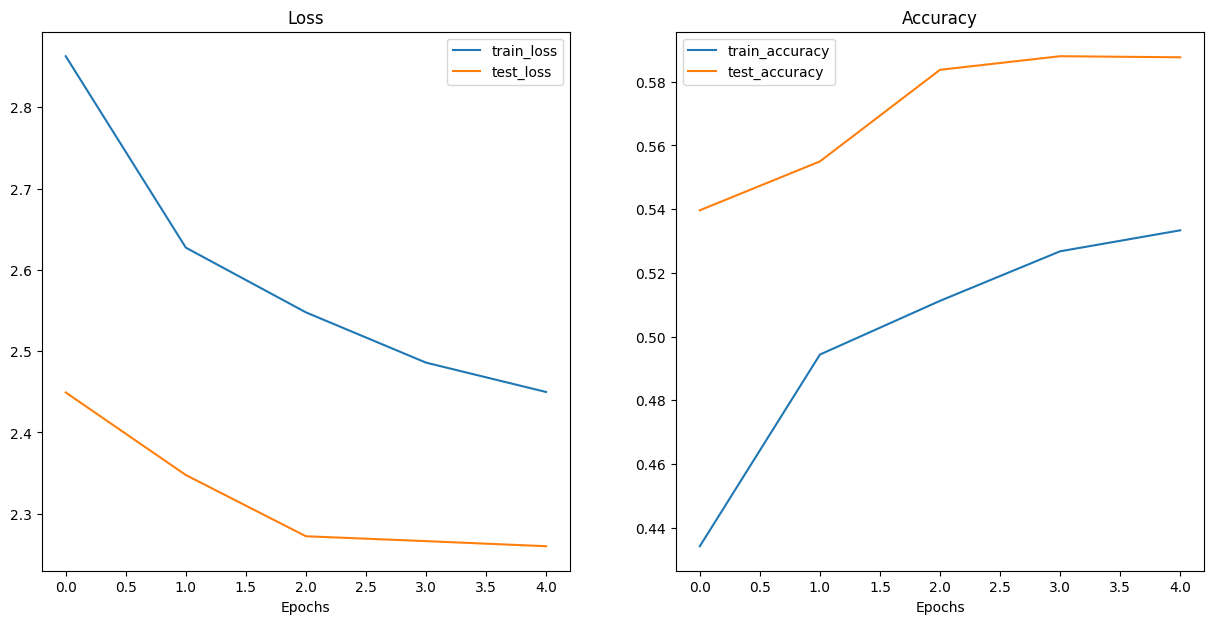

In [161]:
# plot loss curveies
plot_loss_curves(effnetb2_food101_results)

### 10.7 Saving and loading FoodVision Big

Now we've trained our biggest model yet, let's save it so we can load it back in later.

In [162]:
# create a model path
effnetb2_food101_model_path = "09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"

# save FoodVisioon Big Model
save_model (model = effnetb2_food101,
            target_dir = 'models',
            model_name = effnetb2_food101_model_path)

[INFO] Saving model to: models\09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth


In [165]:
# create Food101 compatible EffNetB2 instance
loaded_effnetb2_food101, effnetb2_transforms = create_effnetb2(output_feature_count = 101)

# Load the saved model's state_dict()
loaded_effnetb2_food101.load_state_dict(torch.load("models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"))

[INFO] created new effnetb2 model


<All keys matched successfully>

### 10.8 Checking FoodVision Big model size

Our FoodVision Big model is capable of classifying 101 classes versus FoodVision Mini's 3 classes, a 33.6x increase!

How does this effect the model size?

Let's find out.

In [168]:
pretrained_effnetb2_food101_model_size = Path ('models', effnetb2_food101_model_path).stat().st_size//(1024*1024)
print (f'Pretrained EffNetBw feature extractor Food101 model size: {pretrained_effnetb2_food101_model_size}MB')

Pretrained EffNetBw feature extractor Food101 model size: 30MB


## 11. Turning our FoodVision Big model into a deployable app

We've got a trained and saved EffNetB2 model on 20% of the Food101 dataset.

And instead of letting our model live in a folder all its life, let's deploy it!

We'll deploy our FoodVision Big model in the same way we deployed our FoodVision Mini model, as a Gradio demo on Hugging Face Spaces.

To begin, let's create a `demos/foodvision_big/` directory to store our FoodVision Big demo files as well as a `demos/foodvision_big/examples` directory to hold an example image to test the demo with.

When we're finished we'll have the following file structure:

```
demos/
  foodvision_big/
    09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth
    app.py
    class_names.txt
    examples/
      example_1.jpg
    model.py
    requirements.txt
```

Where:
* `09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth` is our trained PyTorch model file.
* `app.py` contains our FoodVision Big Gradio app.
* `class_names.txt` contains all of the class names for FoodVision Big.
* `examples/` contains example images to use with our Gradio app.
* `model.py` contains the model defintion as well as any transforms assosciated with the model.
* `requirements.txt` contains the dependencies to run our app such as `torch`, `torchvision` and `gradio`.

In [170]:
# create Foodvision big demo path
foodvision_big_demo_path = Path('demos/foodvision_big')

# make the dmeo directory
foodvision_big_demo_path.mkdir (parents = True, exist_ok= True)

# make examples directory
(food_mini_demo_path/'examples').mkdir (parents=True, exist_ok = True)

In [177]:
# (food_mini_demo_path/'examples').mkdir (parents=True, exist_ok = True)
# print(food_mini_demo_path.exists())  # Should be True
# print(food_mini_demo_path.is_dir())  # Should be True
print((food_mini_demo_path/'examples').exists())  # Should be True
print((food_mini_demo_path/'examples').is_dir())  # Should be True

True
True


### 11.1 Downloading an example image and moving it to the `examples` directory

For our example image, we're going to use the faithful [`pizza-dad` image](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/04-pizza-dad.jpeg) (a photo of my dad eating pizza).

So let's download it from the course GitHub via the `!wget` command and then we can move it to `demos/foodvision_big/examples` with the `!mv` command (short for "move").

While we're here we'll move our trained Food101 EffNetB2 model from `models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth` to `demos/foodvision_big` as well.

In [ ]:
# # Download and move an example image
# !wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg 
# # !mv 04-pizza-dad.jpeg demos/foodvision_big/examples/04-pizza-dad.jpg
# !move 04-pizza-dad.jpeg demos/foodvision_big/examples/04-pizza-dad.jpg
# # Move trained model to FoodVision Big demo folder (will error if model is already moved)
# # !mv models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth demos/foodvision_big
# !move models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth demos/foodvision_big

In [183]:
# import os

# # Get the current working directory
# current_path = os.getcwd()
# print("Current Path:", current_path)
import os
import shutil

# Define the file name and subdirectory name
file_name = '04-pizza-dad.jpeg'  # Replace with your file name
subdirectory_name = food_mini_demo_path/'examples'  # Replace with your subdirectory name

# Get the current working directory
current_directory = os.getcwd()

# Define the full path for the source file and destination subdirectory
source_path = os.path.join(current_directory, file_name)
destination_path = os.path.join(current_directory, subdirectory_name, file_name)

# Check if the file exists in the current directory
if not os.path.exists(source_path):
    print(f"Error: File '{file_name}' does not exist in the current directory.")
else:
    # Create the subdirectory if it doesn't exist
    os.makedirs(os.path.join(current_directory, subdirectory_name), exist_ok=True)

    # Move the file to the subdirectory
    shutil.move(source_path, destination_path)
    print(f"File '{file_name}' moved to '{subdirectory_name}' successfully.")

File '04-pizza-dad.jpeg' moved to 'demos\foodvision_mini\examples' successfully.


### 11.2 Saving Food101 class names to file (`class_names.txt`)

Because there are so many classes in the Food101 dataset, instead of storing them as a list in our `app.py` file, let's saved them to a `.txt` file and read them in when necessary instead.

We'll just remind ourselves what they look like first by checking out `food101_class_names`.

In [184]:
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [186]:
# create path to Food101 class name
foodvision_big_class_names_path = foodvision_big_demo_path / "class_names.txt"
with open(foodvision_big_class_names_path, 'w') as f:
    print (f'[INFO] saving food viesion class name s to {foodvision_big_class_names_path}')
    f.write('\n'.join(food101_class_names))

[INFO] saving food viesion class name s to demos\foodvision_big\class_names.txt


In [191]:
with open (foodvision_big_class_names_path, 'r') as f:
    food101_class_names_loaded = [food.strip() for food in f.readlines()]

# food101_class_names_loaded[:5]
len(food101_class_names_loaded)



101

### 11.3 Turning our FoodVision Big model into a Python script (`model.py`)

Just like the FoodVision Mini demo, let's create a script that's capable of instantiating an EffNetB2 feature extractor model along with its necessary transforms.

In [190]:
%%writefile demos/foodvision_big/model.py
import torch
import torchvision

from torch import nn

def create_effnetb2_model (output_feature_count:int=3, drop_out = 0.3, seed:int=42)-> nn.Module:
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms= weights.transforms()
    # model = torchvision.models.efficientnet_b2(weights="DEFAULT").to(device)
    # model = torchvision.models.efficientnet_b2(weights=weights).to(device)
    model = torchvision.models.efficientnet_b2(weights=weights)


    # for param in model.features.parameters():
    for param in model.parameters():
                param.requires_grad = False

    # set_seeds()
    torch.manual_seed(seed)

    last_layer = list(model.children())[-1]
    last_child_layer = list(last_layer.children())[-1]
    last_input = last_child_layer.in_features

    model.classifier = nn.Sequential(
        nn.Dropout(p = drop_out, inplace=True),
        nn.Linear(in_features =last_input, 
                #   out_features = output_feature_count).to(device))
                  out_features = output_feature_count))                 

    # model.name = 'effnetb2'
    # print (f'[INFO] created new {model.name} model')
    
    return model, transforms

Writing demos/foodvision_big/model.py


### 11.4 Turning our FoodVision Big Gradio app into a Python script (`app.py`)

We've got a FoodVision Big `model.py` script, now let's create a FoodVision Big `app.py` script.

This will again mostly be the same as the FoodVision Mini `app.py` script except we'll change:

1. **Imports and class names setup** - The `class_names` variable will be a list for all of the Food101 classes rather than pizza, steak, sushi. We can access these via `demos/foodvision_big/class_names.txt`.
2. **Model and transforms preparation** - The `model` will have `num_classes=101` rather than `num_classes=3`. We'll also be sure to load the weights from `"09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"` (our FoodVision Big model path).
3. **Predict function** - This will stay the same as FoodVision Mini's `app.py`.
4. **Gradio app** - The Gradio interace will have different `title`, `description` and `article` parameters to reflect the details of FoodVision Big.

We'll also make sure to save it to `demos/foodvision_big/app.py` using the `%%writefile` magic command.

In [196]:
# %%writefile demos/foodvision_big/app.py
# 1. import and setup
import gradio as gr
import os
import torch

# from model import create_effnetb2_model # put back in
from timeit import default_repeat as timer  
from typing import Tuple, Dict

# class_names = ['pizza', 'steak', 'sushi']
# with open ('class_names.txt', 'r') as f: # put back iin
with open ('demos/foodvision_big/class_names.txt', 'r') as f:    
    class_names = [food_name.strip() for food_name in f.readlines()]

# 2. Models and Transforms
effnetb2, effnetb2_transforms = create_effnetb2_model(output_feature_count=len(class_names))

effnetb2.load_state_dict(
    torch.load(
        # f=f"models/09_pre_trained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent_{10}_epochs.pth",
        # f="09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth",        
        f="models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth",  
                        map_location=torch.device('cpu'),
        weights_only = True
    )
)

# 3. Predict Funciton
# def predict(img) -> Tuple[Dict, float]
# recreate workflow
def predict(img) ->Tuple [Dict, float]:
    from timeit import default_timer as timer
    start_time = timer()

    img = effnetb2_transforms(img).unsqueeze(0)

    effnetb2.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(effnetb2(img), dim = 1)

    pred_labels_probs = {class_names[i]:float (pred_probs[0][i]) for i in range (len(class_names))}

    pred_time = round (timer() - start_time , 5)

    return pred_labels_probs, pred_time

#  4. Gradio Ap
title = "Food vision Big 🍔👁"
description = "an EfficentNetB2 feature extract 101 items"
article = "Created at Hassan 09 Food Vision 101"

# these will likely cause problems in relative paths. Need to fix. 
# example_list = [[str(filepath)] for filepath in random.sample (test_data_paths, k = 3)]
example_list = [['examples/' + example] for example in os.listdir('examples')]

demo = gr.Interface(fn=predict,
                    inputs = gr.Image(type='pil'),
                    outputs = [gr.Label(num_top_classes = 5, label = "Predictions"),
                                gr.Number(label = "prediction time")],
                    examples = example_list,
                    title = title,
                    description=description,
                    article=article)

demo.launch(debug=False,
           share=True)

* Running on local URL:  http://127.0.0.1:7861

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.
